In [1]:
############################################
# 1. SETUP & IMPORTS
############################################

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Reduce TensorFlow verbosity
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # In case any PyTorch code is used

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from collections import Counter
import csv

from transformers import (
    pipeline,
    AutoTokenizer,
    TFAutoModelForTokenClassification  # TensorFlow model for token classification
)
from datasets import Dataset, DatasetDict
import evaluate

# Download required NLTK resources
nltk.download('punkt')
nltk.download('words')

############################################
# 2. LOAD & EXPLORE FOLKTALES DATA
############################################

df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df["story_id"].duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################################
# 3. CLEAN THE TEXT
############################################

def clean_text_for_ner(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("Sample cleaned text:\n", df["clean_text"].iloc[0][:300], "...\n")

############################################
# 4. SCRAPE CANDIDATE ENTITIES FROM THE WEB
############################################

# 4a. Scrape candidate personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")
scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

# 4b. Scrape candidate town names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")
scraped_towns = set()
tables = soup_towns.find_all("table", class_="wikitable")
for table in tables:
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                if any(bad in candidate.lower() for bad in [
                    "edit", "coordinate", "article", "statement", "isbn",
                    "list of", "administrative", "autonomy", "history", "portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

############################################
# 5. LOAD & MERGE MANUALLY CURATED CANDIDATE CSV
############################################

try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities:")
    print(manual_df.head())
    # Standardize keys: strip and lower-case; fix accidental labels ("B-O" -> "O")
    manual_df["entity_candidate"] = manual_df["entity_candidate"].str.strip().str.lower()
    manual_df["entity"] = manual_df["entity"].str.strip().replace({"B-O": "O", "B-O ": "O"})
    manual_dict = dict(zip(manual_df["entity_candidate"], manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

entity_dict = manual_dict.copy()
for name in scraped_names:
    key = name.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-PER"  # Default scraped personal names as B-PER
for town in scraped_towns:
    key = town.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-LOC"  # Default scraped town names as B-LOC

print("Final Entity Dictionary (sample):")
for key, val in sorted(entity_dict.items())[:20]:
    print(f"{key}: {val}")

final_entity_df = pd.DataFrame(list(entity_dict.items()), columns=["entity_candidate", "entity"])
final_entity_df.to_csv("final_entity_dictionary.csv", index=False)
print("Saved final entity dictionary to 'final_entity_dictionary.csv'.")

############################################
# 6. AUTO-LABEL FOLKTALE TEXTS USING ENTITY DICTIONARY (BIO FORMAT)
############################################

def get_entity_label_bio(token, entity_dict, prev_entity):
    token_lower = token.strip().lower()
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"
    if label == "O":
        return "O", None
    entity_type = label.split("-", 1)[-1]  # e.g., "PER", "LOC", etc.
    if prev_entity == entity_type:
        return f"I-{entity_type}", entity_type
    else:
        return f"B-{entity_type}", entity_type

def auto_label_bio_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity = None
        for token in tokens:
            bio_label, current_entity = get_entity_label_bio(token, entity_dict, prev_entity)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity = current_entity if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for _, row in df.iterrows():
    labeled_tokens = auto_label_bio_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
auto_ner_df.to_csv("auto_ner_data.csv", index=False)
print("\nAuto-labeled DataFrame shape:", auto_ner_df.shape)
print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")

############################################
# 7. GROUP TOKENS BY SENTENCE FOR TRAINING EXAMPLES
############################################

grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })
df_grouped = pd.DataFrame(examples)
print("\nGrouped DataFrame shape:", df_grouped.shape)
print(df_grouped.head())

############################################
# 8. SPLIT TRAIN/VALIDATION & CREATE DATASETS
############################################

train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]
print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################################
# 9. TOKENIZATION & LABEL ALIGNMENT FOR TRAINING
############################################

# Define label list using standard BIO tags.
label_list = ["O", "B-PER", "B-LOC", "B-MISC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# Add special tokens from the entity dictionary to reduce undesired subword splitting.
special_tokens = [k for k in entity_dict.keys() if len(k) > 4]
num_added = tokenizer.add_tokens(special_tokens)
print("\nNumber of special tokens added:", num_added)

# Use a simple collate function based on Keras padding (pad_sequences)
def simple_collate_fn(features):
    collated = {}
    for key in features[0].keys():
        values = [f[key] for f in features]
        # Use pad_sequences from Keras to pad variable-length lists
        collated[key] = tf.keras.preprocessing.sequence.pad_sequences(values, padding='post')
    return collated

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                aligned_labels.append(-100)
            else:
                label_str = example_labels[wid]
                # If a token is split into subwords, change subsequent B- to I-
                if wid == prev_wid and label_str != "O" and label_str.startswith("B-"):
                    label_str = "I-" + label_str[2:]
                aligned_labels.append(label2id.get(label_str, 0))
            prev_wid = wid
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False
)
print("\nProcessed datasets ready for training:")
print(processed_datasets)

############################################
# 10. SHOW LABEL DISTRIBUTION & COMPUTE WEIGHTS
############################################

label_counts = Counter(auto_ner_df["ner_label"])
print("\nLabel distribution in auto_ner_df:", label_counts)
# Compute weights for each label as 1/(count+1)
weight_list = [1.0 / (label_counts.get(lbl, 0) + 1) for lbl in label_list]
weight_tensor = tf.constant(weight_list, dtype=tf.float32)
print("Weight tensor:", weight_tensor.numpy())

############################################
# 11. BUILD & TRAIN THE CUSTOM NER MODEL WITH TENSORFLOW
############################################

from transformers import TFAutoModelForTokenClassification

# Create the TensorFlow model.
model = TFAutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
# Resize token embeddings to account for added special tokens.
try:
    model.resize_token_embeddings(len(tokenizer))
except AttributeError:
    # If not available, update the config manually.
    model.config.vocab_size = len(tokenizer)

# Define a custom loss function that masks out -100 labels.
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    # Mask: 1 where y_true != -100, else 0.
    mask = tf.cast(tf.not_equal(y_true, -100), dtype=tf.float32)
    # Replace -100 with 0.
    y_true_mod = tf.where(tf.equal(y_true, -100), tf.zeros_like(y_true), y_true)
    y_true_mod = tf.cast(y_true_mod, tf.int32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_mod, y_pred, from_logits=True)
    loss = tf.cast(loss, tf.float32) * mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss=masked_sparse_categorical_crossentropy)

# Convert processed datasets to TensorFlow tf.data.Dataset.
train_tf_dataset = processed_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    batch_size=8,
    collate_fn=simple_collate_fn
)
val_tf_dataset = processed_datasets["validation"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    batch_size=8,
    collate_fn=simple_collate_fn
)

print("\nStarting model training with TensorFlow...")
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=5
)

# Save the model and tokenizer.
model.save_pretrained("greenlandic_ner_model_tf")
tokenizer.save_pretrained("greenlandic_ner_model_tf")

############################################
# 12. INFERENCE USING THE TRAINED TENSORFLOW MODEL
############################################

ner_infer = pipeline(
    "ner",
    model="greenlandic_ner_model_tf",
    tokenizer="greenlandic_ner_model_tf",
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("\nInference output on sample text:")
print(ner_infer(test_text))


KeyboardInterrupt: 

/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded. Shape: (51, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
Duplicate story IDs: 0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package words is already up-to-date!


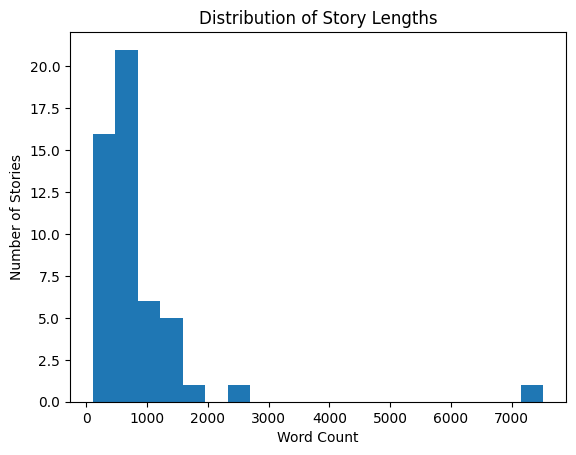


Sample cleaned text (first 300 chars):
 Our forefathers have told us much of the coming of earth, and of men, and it was a long, long while ago. Those who lived long before our day, they did not know how to store their words in little black marks, as you do; they could only tell stories. And they told of many things, and therefore we are  ...

Scraped 337 candidate personal names from Wiktionary.
Scraped 76 candidate town names from Wikipedia.
Loaded manually curated candidate entities (first 5 rows):
  entity_candidate entity
0            Ailaq  B-PER
1             Aluk  B-PER
2           Alátaq  B-PER
3         Amerdloq  B-PER
4          Anarteq  B-PER

Final Entity Dictionary Sample:
aaju: B-PER
aaneeraq: B-PER
aani: B-PER
aaninnguaq: B-PER
aannguaq: B-PER
aappilattoq: B-LOC
aaqa: B-PER
aasiaat: B-LOC
aggu: B-PER
ailaq: B-PER
aima: B-PER
aja: B-PER
ajaaja: B-PER
aka: B-PER
akisooq: B-PER
akitsinnguaq: B-PER
akunnaaq: B-LOC
aleqa: B-PER
alibak: B-PER
alluitsup paa: B-LOC

Auto-label

Map: 100%|██████████| 409/409 [00:00<00:00, 14193.04 examples/s]


Processed datasets ready for training:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1635
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 409
    })
})

Label distribution in auto_ner_df: Counter({'O': 49212, 'B-PER': 390, 'B-MISC': 44, 'B-LOC': 10})



I0000 00:00:1744213603.067001 17759728 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744213603.067039 17759728 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Weight tensor: [2.0319834e-05 2.5575447e-03 9.0909094e-02 2.2222223e-02]


All PyTorch model weights were used when initializing TFXLMRobertaForTokenClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting model training with TensorFlow...
Epoch 1/5
205/205 [==============================] - 1425s 7s/step - loss: 0.0792 - val_loss: 0.0071
Epoch 2/5


InvalidArgumentError: Graph execution error:

Detected at node tfxlm_roberta_for_token_classification/roberta/encoder/layer_._0/attention/self/query/Tensordot/Reshape defined at (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_6330/2530496903.py", line 347, in <module>

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1209, in fit

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1652, in train_step

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1625, in run_call_with_unpacked_inputs

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 1635, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1625, in run_call_with_unpacked_inputs

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 918, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 700, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 706, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 598, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 479, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 342, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/layers/core/dense.py", line 244, in call

Detected at node tfxlm_roberta_for_token_classification/roberta/encoder/layer_._0/attention/self/query/Tensordot/Reshape defined at (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_6330/2530496903.py", line 347, in <module>

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1209, in fit

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1652, in train_step

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1625, in run_call_with_unpacked_inputs

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 1635, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1625, in run_call_with_unpacked_inputs

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 918, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 700, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 706, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 598, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 479, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/transformers/models/xlm_roberta/modeling_tf_xlm_roberta.py", line 342, in call

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/Users/lukaskreibig/Documents/Dokumente Cloud/climate-dashboard/.venv/lib/python3.10/site-packages/tf_keras/src/layers/core/dense.py", line 244, in call

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Input to reshape is a tensor with 337920 values, but the requested shape has 0
	 [[{{node tfxlm_roberta_for_token_classification/roberta/encoder/layer_._0/attention/self/query/Tensordot/Reshape}}]]
	 [[tfxlm_roberta_for_token_classification/roberta/encoder/layer_._8/intermediate/Gelu/mul_1/_476]]
  (1) INVALID_ARGUMENT:  Input to reshape is a tensor with 337920 values, but the requested shape has 0
	 [[{{node tfxlm_roberta_for_token_classification/roberta/encoder/layer_._0/attention/self/query/Tensordot/Reshape}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_22291]

In [1]:
############################################
# 1. SETUP & IMPORTS
############################################

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Reduce TensorFlow verbosity
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"  # (In case any PyTorch code is used)

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from collections import Counter
import csv

from transformers import (
    pipeline,
    AutoTokenizer,
    TFAutoModelForTokenClassification  # TensorFlow model for token classification
)
from datasets import Dataset, DatasetDict
import evaluate

# Download required NLTK resources
nltk.download('punkt')
nltk.download('words')

############################################
# 2. LOAD & EXPLORE FOLKTALES DATA
############################################

df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)
print(df.info())
print("Duplicate story IDs:", df["story_id"].duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

############################################
# 3. CLEAN THE TEXT
############################################

def clean_text_for_ner(text: str) -> str:
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    paragraphs = re.split(r'\n\s*\n+', text.strip())
    cleaned_paragraphs = []
    for para in paragraphs:
        para = re.sub(r'\n+', ' ', para)
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')
        para = re.sub(r'\s+', ' ', para).strip()
        cleaned_paragraphs.append(para)
    return "\n\n".join(cleaned_paragraphs)

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print("\nSample cleaned text (first 300 chars):\n", df["clean_text"].iloc[0][:300], "...\n")

############################################
# 4. SCRAPE CANDIDATE ENTITIES FROM THE WEB
############################################

# 4a. Scrape candidate personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")
scraped_names = set()
for dd in soup_names.select("dl dd"):
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if candidate and len(candidate) > 1:
            scraped_names.add(candidate)
print(f"Scraped {len(scraped_names)} candidate personal names from Wiktionary.")

# 4b. Scrape candidate town names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")
scraped_towns = set()
tables = soup_towns.find_all("table", class_="wikitable")
for table in tables:
    for row in table.find_all("tr"):
        for link in row.find_all("a", href=True):
            candidate = link.get_text(strip=True)
            if candidate and len(candidate) > 1:
                # Skip noisy links
                if any(bad in candidate.lower() for bad in [
                    "edit", "coordinate", "article", "statement", "isbn",
                    "list of", "administrative", "autonomy", "history", "portal"
                ]):
                    continue
                scraped_towns.add(candidate)
print(f"Scraped {len(scraped_towns)} candidate town names from Wikipedia.")

############################################
# 5. LOAD & MERGE MANUALLY CURATED CANDIDATE CSV
############################################

# If available, load a CSV of manually curated candidate entities.
try:
    manual_df = pd.read_csv("candidate_entities_finished.csv")
    print("Loaded manually curated candidate entities (first 5 rows):")
    print(manual_df.head())
    # Standardize keys: lower-case and strip; fix accidental labels.
    manual_df["entity_candidate"] = manual_df["entity_candidate"].str.strip().str.lower()
    manual_df["entity"] = manual_df["entity"].str.strip().replace({"B-O": "O", "B-O ": "O"})
    manual_dict = dict(zip(manual_df["entity_candidate"], manual_df["entity"]))
except Exception as e:
    print("Manual candidate CSV not found; proceeding with scraped data only.")
    manual_dict = {}

entity_dict = manual_dict.copy()
for name in scraped_names:
    key = name.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-PER"  # Default scraped personal names as B-PER
for town in scraped_towns:
    key = town.strip().lower()
    if key not in entity_dict:
        entity_dict[key] = "B-LOC"  # Default scraped town names as B-LOC

print("\nFinal Entity Dictionary Sample:")
for key, val in sorted(entity_dict.items())[:20]:
    print(f"{key}: {val}")

# (Here we do not save the dictionary to disk; we just print a sample.)

############################################
# 6. AUTO-LABEL FOLKTALE TEXTS USING ENTITY DICTIONARY (BIO FORMAT)
############################################

def get_entity_label_bio(token, entity_dict, prev_entity):
    token_lower = token.strip().lower()
    if token_lower in entity_dict:
        label = entity_dict[token_lower]
    elif token_lower.endswith("s"):
        label = entity_dict.get(token_lower[:-1], "O")
    else:
        label = "O"
    if label == "O":
        return "O", None
    entity_type = label.split("-", 1)[-1]  # e.g., PER, LOC, etc.
    if prev_entity == entity_type:
        return f"I-{entity_type}", entity_type
    else:
        return f"B-{entity_type}", entity_type

def auto_label_bio_using_dict(text, entity_dict):
    sentences = nltk.sent_tokenize(text)
    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        prev_entity = None
        for token in tokens:
            bio_label, current_entity = get_entity_label_bio(token, entity_dict, prev_entity)
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": bio_label
            })
            prev_entity = current_entity if bio_label != "O" else None
    return data_rows

all_rows = []
doc_id = 0
for _, row in df.iterrows():
    labeled_tokens = auto_label_bio_using_dict(row["clean_text"], entity_dict)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
print("\nAuto-labeled DataFrame shape:", auto_ner_df.shape)
print("Sample of auto-labeled data (first 10 rows):")
print(auto_ner_df.head(10))

############################################
# 7. GROUP TOKENS BY SENTENCE FOR TRAINING EXAMPLES
############################################

grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])
examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })
df_grouped = pd.DataFrame(examples)
print("\nGrouped DataFrame shape:", df_grouped.shape)
print("First 5 training examples:")
print(df_grouped.head())

############################################
# 8. SPLIT TRAIN/VALIDATION & CREATE DATASETS
############################################

train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]
print("\nTrain size:", train_df.shape)
print("Validation size:", val_df.shape)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

############################################
# 9. TOKENIZATION & LABEL ALIGNMENT FOR TRAINING
############################################

# Define label list (standard BIO tags)
label_list = ["O", "B-PER", "B-LOC", "B-MISC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# Add special tokens from the entity dictionary to reduce undesired subword splitting.
special_tokens = [k for k in entity_dict.keys() if len(k) > 4]
num_added = tokenizer.add_tokens(special_tokens)
print("\nNumber of special tokens added to tokenizer:", num_added)

# We'll use a simple collate function based on Keras pad_sequences.
def simple_collate_fn(features):
    import tensorflow as tf
    collated = {}
    for key in features[0].keys():
        values = [f[key] for f in features]
        # Pad each key using Keras pad_sequences so each batch has the same shape.
        collated[key] = tf.keras.preprocessing.sequence.pad_sequences(values, padding='post')
    return collated

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )
    all_labels = []
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                aligned_labels.append(-100)
            else:
                label_str = example_labels[wid]
                # For contiguous subwords, convert a following B- to I-
                if wid == prev_wid and label_str != "O" and label_str.startswith("B-"):
                    label_str = "I-" + label_str[2:]
                aligned_labels.append(label2id.get(label_str, 0))
            prev_wid = wid
        all_labels.append(aligned_labels)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=False  # Disable caching to save disk space
)
print("\nProcessed datasets ready for training:")
print(processed_datasets)

############################################
# 10. SHOW LABEL DISTRIBUTION & COMPUTE WEIGHTS
############################################

label_counts = Counter(auto_ner_df["ner_label"])
print("\nLabel distribution in auto_ner_df:", label_counts)
# Compute class weights as 1/(count+1) for each label in our label list.
weight_list = [1.0 / (label_counts.get(lbl, 0) + 1) for lbl in label_list]
weight_tensor = tf.constant(weight_list, dtype=tf.float32)
print("Weight tensor:", weight_tensor.numpy())

############################################
# 11. BUILD & TRAIN THE CUSTOM NER MODEL WITH TENSORFLOW
############################################

from transformers import TFAutoModelForTokenClassification

# Create the TensorFlow model.
model = TFAutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)
# Resize model embeddings to account for added special tokens.
try:
    model.resize_token_embeddings(len(tokenizer))
except AttributeError:
    print("resize_token_embeddings not available; updating model.config.vocab_size.")
    model.config.vocab_size = len(tokenizer)

# Define a custom loss function that masks out -100 labels.
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, -100), dtype=tf.float32)
    y_true_mod = tf.where(tf.equal(y_true, -100), tf.zeros_like(y_true), y_true)
    y_true_mod = tf.cast(y_true_mod, tf.int32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_mod, y_pred, from_logits=True)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss=masked_sparse_categorical_crossentropy)

# Convert processed datasets to TensorFlow tf.data.Dataset.
train_tf_dataset = processed_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    batch_size=8,
    collate_fn=simple_collate_fn
)
val_tf_dataset = processed_datasets["validation"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    batch_size=8,
    collate_fn=simple_collate_fn
)

print("\nStarting model training with TensorFlow...")
history = model.fit(
    train_tf_dataset,
    validation_data=val_tf_dataset,
    epochs=5
)

############################################
# 12. INFERENCE USING THE TRAINED TENSORFLOW MODEL
############################################

ner_infer = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"
)

test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
print("\nInference output on sample text:")
print(ner_infer(test_text))
